# Obtain a decent score with just 11 distances and 10 types

Inspired by the really cool kernel "Distance - is all you need" (https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481), I tried to devise my own system of simple, geomtric features. I started out with the simplest set of distance-features, I could think of.

## Steps

* Calculate the center-point on the axis between the two j-coupled atoms
  (let's refer to them as atom_0 and and atom_1)
* Get the 10 closet atoms and rank them by their distance to the center point (from closest to farthest away)


## Features
Now, or each of the 10-nearest neighbor atoms, we have 3 features:

* atom-type
* distance from the center-point
   
Adding the distance between atom_0 and atom_1 gives at total of 21 features.

    
## Intuition

These features provide three sources of information:

* Which atom: H, C, N, O, or F
* How far away from the j-coupled atoms


## Model

The same LGBM used in the above mentioned kernel.  
Only more estimators are used for test-set prediction

## Limitations

The decent score given the simple features suggests that geometry and atom type is all you need (it's also all you got ... :-D).
However, this simple approach suffers from 3 main drawbacks:

#### Lack of geometric information:

Distance get's you surprisingly far, but has it's limitations. This features contain no information about whether a neighbor atom is on the side of atom_0, on the side of atom_1 or orthogonal to the atom_0-atom_1 axis. This is obviously a severe limation and it's surprising, the approch even reaches a relativels decent score.

#### Permutation
  A small difference in distances can lead to a different order of neighbor-atoms. This way very similar geometries can end up a different feature ordering which impedes learning.
... that's why Message Passing Neural Networks or Graph Neural networks are used: the employ permutation invariant aggregation functions, such as $sum$ or $mean$.
  
#### No feature structure

The 21 features above are not simply 21 scalar features. Obviously there is some structure:
For each atom, the features type and distance belong togheter. However, the model can't account for this structure when it's simply provided a list of features.

## Runtime

It takes forever.  
The computation was not optimized due to the inherent limitations of the approach explained above :-)

In [1]:
%%capture

import os
from os.path import join
import sys
from pprint import pprint

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial import distance_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

DATA_DIR = '../input/champs-scalar-coupling'
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

# Load Data

In [2]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_df = pd.read_csv(join(DATA_DIR, 'structures.csv'), dtype=structures_dtypes)

structures_df['molecule_index'] = structures_df.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_df['atom'] = structures_df['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_df.index = structures_df.molecule_index
structures_df = structures_df[['atom_index', 'atom', 'x', 'y', 'z']]

structures_df[['x', 'y', 'z']] = structures_df[['x', 'y', 'z']] / 10  # puts all distances approx. in range [0, 1]
print(structures_df.shape)
display(structures_df.head())

(2358657, 5)


,atom_index,atom,x,y,z
molecule_index,,,,,
1,0,6,-0.001270,0.108580,0.000800
1,1,1,0.000215,-0.000603,0.000198
1,2,1,0.101173,0.146375,0.000028
1,3,1,-0.054082,0.144753,-0.087664
1,4,1,-0.052381,0.143793,0.090640


In [3]:
"""
These two functions are from this cool kernel:
https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481
"""

def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df


def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

In [4]:
def load_j_coupling_csv(file_path: str, train=True, verbose=False):
    train_dtypes = {
        'molecule_name': 'category',
        'atom_index_0': 'int8',
        'atom_index_1': 'int8',
        'type': 'category',
        'scalar_coupling_constant': 'float32'
    }
    df = pd.read_csv(file_path, dtype=train_dtypes)
    df['molecule_index'] = df.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
    
    if train:
        cols = ['id', 'molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']
    else: 
        cols = ['id', 'molecule_index', 'atom_index_0', 'atom_index_1', 'type']
    df = df[cols]

    df = add_coordinates(df, structures_df, 0)
    df = add_coordinates(df, structures_df, 1)
    add_center(df)
    
    if verbose:
        print(df.shape)
        display(df.head())
        
    return df


train_df = load_j_coupling_csv(join(DATA_DIR, 'train.csv'), verbose=True)

mol2distance_matrix = structures_df.groupby('molecule_index').apply(
    lambda df: distance_matrix(df[['x','y', 'z']].values, df[['x','y', 'z']].values))

(4658147, 17)


,id,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,x_c,y_c,z_c
0,0,1,1,0,1JHC,84.807602,1,0.000215,-0.000603,0.000198,6,-0.001270,0.108580,0.000800,-0.000527,0.053989,0.000499
1,4,1,2,0,1JHC,84.807404,1,0.101173,0.146375,0.000028,6,-0.001270,0.108580,0.000800,0.049952,0.127478,0.000414
2,7,1,3,0,1JHC,84.809303,1,-0.054082,0.144753,-0.087664,6,-0.001270,0.108580,0.000800,-0.027676,0.126667,-0.043432
3,9,1,4,0,1JHC,84.809502,1,-0.052381,0.143793,0.090640,6,-0.001270,0.108580,0.000800,-0.026826,0.126187,0.045720
4,1,1,1,2,2JHH,-11.257000,1,0.000215,-0.000603,0.000198,1,0.101173,0.146375,0.000028,0.050694,0.072886,0.000113


# Calculate Features

In [5]:
def get_knn_features_center(j_coupling: pd.Series,
                            structures=structures_df,
                            mol2dist=mol2distance_matrix,
                            k=10) -> np.array:
    
    center      = j_coupling[['x_c', 'y_c', 'z_c']].values.reshape(1, 3)
    mol_df      = structures.loc[j_coupling.molecule_index]
    coordinates = mol_df[['x','y', 'z']].values
    
    center_distances = distance_matrix(center, coordinates).ravel()
    knn = np.argsort(center_distances)[:(k + 2)]  # atom-indices of KNN-atoms
    
    a_0, a_1 = j_coupling.atom_index_0, j_coupling.atom_index_1
    knn = np.array([x for x in knn if x not in (a_0, a_1)])
    
    distances = center_distances[knn]
    types = mol_df.iloc[knn].atom
    
    distances = np.pad(distances, (0, k - len(distances)), 'constant')
    types =     np.pad(types,     (0, k - len(types)),     'constant')
    
    dist_matrix = mol2distance_matrix[j_coupling.molecule_index]
    d_a0_a1 = dist_matrix[a_0, a_1]

    knn_features = np.concatenate([[d_a0_a1], distances, types])
    return knn_features


# this may take a while...
id2center_knn = {row.id : get_knn_features_center(row) for _, row in train_df.iterrows()}

# Make Model

In [6]:
def make_data(df: pd.DataFrame, id2features: dict, random_state=128, split=True):
    tmp_df = df.copy()
    tmp_df['features'] = tmp_df.id.map(id2features)
    
    X = np.stack(tmp_df.features)
    y = tmp_df.scalar_coupling_constant.values

    if split:
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)
        return (X_train, y_train), (X_val, y_val)
    else:
        return X, y

    
# hyper-parameters like in this kernel:
# https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481
LGB_PARAMS = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.2,
        'num_leaves': 128,
        'min_child_samples': 79,
        'max_depth': 9,
        'subsample_freq': 1,
        'subsample': 0.9,
        'bagging_seed': 11,
        'reg_alpha': 0.1,
        'reg_lambda': 0.3,
        'colsample_bytree': 1.0
        }

    
def train_model(train, validation):
    
    X_train, y_train = train
    X_val,   y_val   = validation

    model = LGBMRegressor(**LGB_PARAMS, n_estimators=1500, n_jobs = -1)  # 6000 estimators would be better but take much longer
    model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
            verbose=100, early_stopping_rounds=200)

    y_pred    = model.predict(X_val)
    score     = np.log(mean_absolute_error(y_val, y_pred))
    residuals = y_val - y_pred
    
    print(f'competition-metric score: {score}')
    return model, score, residuals


def plot_residuals(residuals: np.array):
    plt.hist(residuals, bins=50)
    plt.title('residual distribution')
    plt.show();

(34690, 21) (8673, 21) (34690,) (8673,)
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.532881	valid_1's l1: 0.670551
[200]	training's l1: 0.439862	valid_1's l1: 0.614787
[300]	training's l1: 0.379465	valid_1's l1: 0.588082
[400]	training's l1: 0.335979	valid_1's l1: 0.570625
[500]	training's l1: 0.301379	valid_1's l1: 0.557352
[600]	training's l1: 0.271864	valid_1's l1: 0.548635
[700]	training's l1: 0.24678	valid_1's l1: 0.541042
[800]	training's l1: 0.225911	valid_1's l1: 0.534845
[900]	training's l1: 0.207728	valid_1's l1: 0.530711
[1000]	training's l1: 0.191991	valid_1's l1: 0.526081
[1100]	training's l1: 0.177408	valid_1's l1: 0.522283
[1200]	training's l1: 0.163927	valid_1's l1: 0.519518
[1300]	training's l1: 0.1531	valid_1's l1: 0.517195
[1400]	training's l1: 0.142643	valid_1's l1: 0.515209
[1500]	training's l1: 0.132961	valid_1's l1: 0.513841
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.132961	valid_1's l1: 0.5138

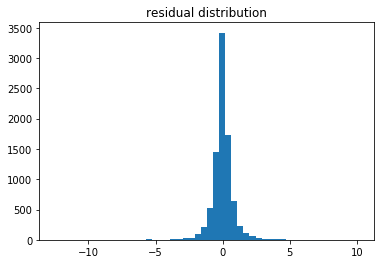

In [7]:
# test pipeline with smallest type:

sub_train_df = train_df.query('type == "1JHN"')

(X_train, y_train), (X_val, y_val) = make_data(sub_train_df, id2center_knn)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

model, score, residuals = train_model((X_train, y_train), (X_val, y_val))
plot_residuals(residuals)

# Cross-validate



### 1JHC
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 1.42567	valid_1's l1: 1.47848
[200]	training's l1: 1.2437	valid_1's l1: 1.32652
[300]	training's l1: 1.13749	valid_1's l1: 1.24571
[400]	training's l1: 1.06286	valid_1's l1: 1.19339
[500]	training's l1: 1.00176	valid_1's l1: 1.15277
[600]	training's l1: 0.954723	valid_1's l1: 1.12442
[700]	training's l1: 0.914683	valid_1's l1: 1.10115
[800]	training's l1: 0.880119	valid_1's l1: 1.08312
[900]	training's l1: 0.848239	valid_1's l1: 1.06607
[1000]	training's l1: 0.819138	valid_1's l1: 1.05139
[1100]	training's l1: 0.79296	valid_1's l1: 1.03871
[1200]	training's l1: 0.768191	valid_1's l1: 1.0268
[1300]	training's l1: 0.74649	valid_1's l1: 1.01676
[1400]	training's l1: 0.726437	valid_1's l1: 1.00798
[1500]	training's l1: 0.707459	valid_1's l1: 1.00018
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.707459	valid_1's l1: 1.00018
competition-metric score: 0.00018613021897154034

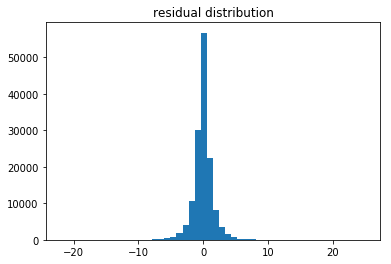



### 1JHN
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.532881	valid_1's l1: 0.670551
[200]	training's l1: 0.439862	valid_1's l1: 0.614787
[300]	training's l1: 0.379465	valid_1's l1: 0.588082
[400]	training's l1: 0.335979	valid_1's l1: 0.570625
[500]	training's l1: 0.301379	valid_1's l1: 0.557352
[600]	training's l1: 0.271864	valid_1's l1: 0.548635
[700]	training's l1: 0.24678	valid_1's l1: 0.541042
[800]	training's l1: 0.225911	valid_1's l1: 0.534845
[900]	training's l1: 0.207728	valid_1's l1: 0.530711
[1000]	training's l1: 0.191991	valid_1's l1: 0.526081
[1100]	training's l1: 0.177408	valid_1's l1: 0.522283
[1200]	training's l1: 0.163927	valid_1's l1: 0.519518
[1300]	training's l1: 0.1531	valid_1's l1: 0.517195
[1400]	training's l1: 0.142643	valid_1's l1: 0.515209
[1500]	training's l1: 0.132961	valid_1's l1: 0.513841
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.132961	valid_1's l1: 0.513841
competition-metric score: 

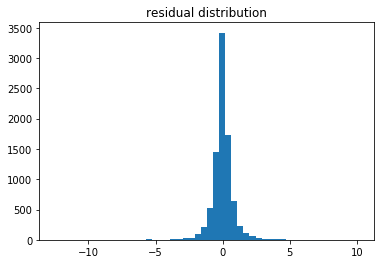



### 2JHC
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.715104	valid_1's l1: 0.73743
[200]	training's l1: 0.621632	valid_1's l1: 0.655799
[300]	training's l1: 0.567917	valid_1's l1: 0.612026
[400]	training's l1: 0.531733	valid_1's l1: 0.583967
[500]	training's l1: 0.502718	valid_1's l1: 0.562244
[600]	training's l1: 0.479763	valid_1's l1: 0.546585
[700]	training's l1: 0.460266	valid_1's l1: 0.533601
[800]	training's l1: 0.443322	valid_1's l1: 0.522736
[900]	training's l1: 0.428588	valid_1's l1: 0.513798
[1000]	training's l1: 0.415133	valid_1's l1: 0.505573
[1100]	training's l1: 0.403308	valid_1's l1: 0.499039
[1200]	training's l1: 0.392222	valid_1's l1: 0.492894
[1300]	training's l1: 0.381876	valid_1's l1: 0.487255
[1400]	training's l1: 0.372674	valid_1's l1: 0.48258
[1500]	training's l1: 0.363503	valid_1's l1: 0.477716
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.363503	valid_1's l1: 0.477716
competition-metric score:

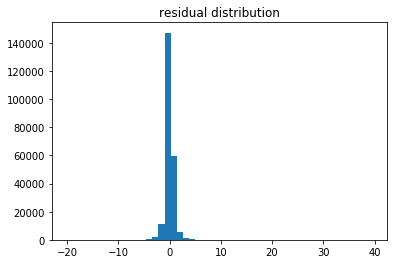



### 2JHH
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.26694	valid_1's l1: 0.288706
[200]	training's l1: 0.224941	valid_1's l1: 0.256385
[300]	training's l1: 0.201825	valid_1's l1: 0.240636
[400]	training's l1: 0.186103	valid_1's l1: 0.231236
[500]	training's l1: 0.173986	valid_1's l1: 0.224635
[600]	training's l1: 0.163961	valid_1's l1: 0.219528
[700]	training's l1: 0.155234	valid_1's l1: 0.215202
[800]	training's l1: 0.148222	valid_1's l1: 0.211995
[900]	training's l1: 0.141479	valid_1's l1: 0.208925
[1000]	training's l1: 0.135633	valid_1's l1: 0.206449
[1100]	training's l1: 0.130118	valid_1's l1: 0.204166
[1200]	training's l1: 0.12532	valid_1's l1: 0.202288
[1300]	training's l1: 0.120982	valid_1's l1: 0.200808
[1400]	training's l1: 0.116855	valid_1's l1: 0.199369
[1500]	training's l1: 0.112942	valid_1's l1: 0.197975
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.112942	valid_1's l1: 0.197975
competition-metric score:

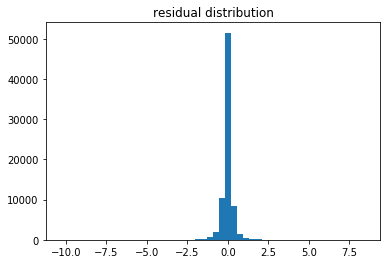



### 2JHN
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.223991	valid_1's l1: 0.260947
[200]	training's l1: 0.184794	valid_1's l1: 0.233546
[300]	training's l1: 0.164154	valid_1's l1: 0.221168
[400]	training's l1: 0.148296	valid_1's l1: 0.212764
[500]	training's l1: 0.135813	valid_1's l1: 0.207127
[600]	training's l1: 0.12512	valid_1's l1: 0.202646
[700]	training's l1: 0.116372	valid_1's l1: 0.199165
[800]	training's l1: 0.107992	valid_1's l1: 0.195908
[900]	training's l1: 0.100572	valid_1's l1: 0.193104
[1000]	training's l1: 0.093835	valid_1's l1: 0.190775
[1100]	training's l1: 0.0880705	valid_1's l1: 0.188955
[1200]	training's l1: 0.0830582	valid_1's l1: 0.187389
[1300]	training's l1: 0.0781183	valid_1's l1: 0.185694
[1400]	training's l1: 0.0736662	valid_1's l1: 0.184453
[1500]	training's l1: 0.0696596	valid_1's l1: 0.183317
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0696596	valid_1's l1: 0.183317
competition-metric

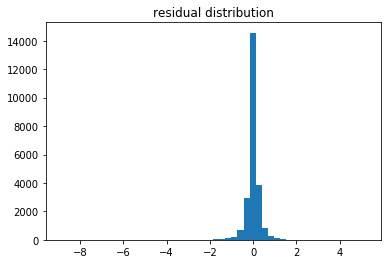



### 3JHC
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.662624	valid_1's l1: 0.67389
[200]	training's l1: 0.58393	valid_1's l1: 0.602311
[300]	training's l1: 0.540439	valid_1's l1: 0.565212
[400]	training's l1: 0.509884	valid_1's l1: 0.540247
[500]	training's l1: 0.486226	valid_1's l1: 0.521866
[600]	training's l1: 0.467406	valid_1's l1: 0.507743
[700]	training's l1: 0.450827	valid_1's l1: 0.495866
[800]	training's l1: 0.436769	valid_1's l1: 0.485985
[900]	training's l1: 0.424298	valid_1's l1: 0.477639
[1000]	training's l1: 0.413105	valid_1's l1: 0.470151
[1100]	training's l1: 0.40295	valid_1's l1: 0.463699
[1200]	training's l1: 0.393738	valid_1's l1: 0.458128
[1300]	training's l1: 0.385378	valid_1's l1: 0.453275
[1400]	training's l1: 0.377452	valid_1's l1: 0.448522
[1500]	training's l1: 0.369998	valid_1's l1: 0.444307
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.369998	valid_1's l1: 0.444307
competition-metric score: 

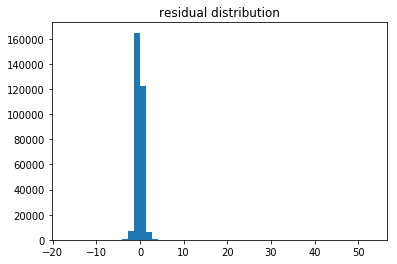



### 3JHH
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.272398	valid_1's l1: 0.283109
[200]	training's l1: 0.230601	valid_1's l1: 0.247956
[300]	training's l1: 0.208487	valid_1's l1: 0.230996
[400]	training's l1: 0.193379	valid_1's l1: 0.220097
[500]	training's l1: 0.181583	valid_1's l1: 0.212102
[600]	training's l1: 0.172422	valid_1's l1: 0.206421
[700]	training's l1: 0.164398	valid_1's l1: 0.201594
[800]	training's l1: 0.157586	valid_1's l1: 0.197717
[900]	training's l1: 0.151659	valid_1's l1: 0.194669
[1000]	training's l1: 0.146279	valid_1's l1: 0.19196
[1100]	training's l1: 0.141431	valid_1's l1: 0.189619
[1200]	training's l1: 0.136879	valid_1's l1: 0.187477
[1300]	training's l1: 0.132833	valid_1's l1: 0.185541
[1400]	training's l1: 0.128914	valid_1's l1: 0.183714
[1500]	training's l1: 0.12548	valid_1's l1: 0.182246
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.12548	valid_1's l1: 0.182246
competition-metric score: 

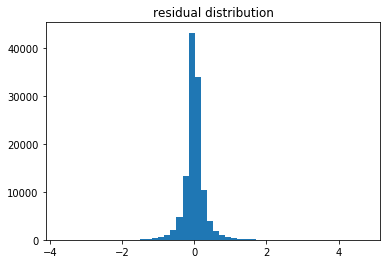



### 3JHN
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.194035	valid_1's l1: 0.217133
[200]	training's l1: 0.162121	valid_1's l1: 0.19478
[300]	training's l1: 0.14246	valid_1's l1: 0.182767
[400]	training's l1: 0.128744	valid_1's l1: 0.175353
[500]	training's l1: 0.11849	valid_1's l1: 0.170271
[600]	training's l1: 0.109844	valid_1's l1: 0.166522
[700]	training's l1: 0.102624	valid_1's l1: 0.163428
[800]	training's l1: 0.0960598	valid_1's l1: 0.160661
[900]	training's l1: 0.0904972	valid_1's l1: 0.158569
[1000]	training's l1: 0.0854675	valid_1's l1: 0.156634
[1100]	training's l1: 0.0809292	valid_1's l1: 0.155133
[1200]	training's l1: 0.076739	valid_1's l1: 0.153657
[1300]	training's l1: 0.072927	valid_1's l1: 0.15245
[1400]	training's l1: 0.069603	valid_1's l1: 0.151418
[1500]	training's l1: 0.0665644	valid_1's l1: 0.150437
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0665644	valid_1's l1: 0.150437
competition-metric sc

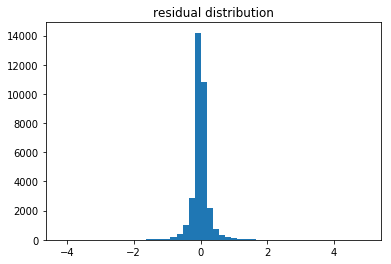

In [8]:
def cross_validate(df, id2features):
    type2model = {}
    scores = {}

    for type_, type_df in df.groupby('type'):
        print(f'\n\n### {type_}')
        train, validation = make_data(type_df, id2features)
        model, score, residuals = train_model(train, validation)
        type2model[type_] = model
        scores[type_] = score
        plot_residuals(residuals)

    assert len(scores) == len(type2model) == 8
    return  scores


scores = cross_validate(train_df, id2center_knn)

In [9]:
print(f'competition-metric: {np.mean(list(scores.values())):.2f}')
print('scores per type:')
pprint(scores, width=1)

competition-metric: -1.14
scores per type:
{'1JHC': 0.00018613021897154034,
 '1JHN': -0.6658155168422749,
 '2JHC': -0.7387288121491017,
 '2JHH': -1.619612848606776,
 '2JHN': -1.6965363443940062,
 '3JHC': -0.811241851624432,
 '3JHH': -1.7023970476833459,
 '3JHN': -1.894199423289528}


# Predict and submit

In [10]:
def make_test_data(df: pd.DataFrame, id2features: dict, random_state=128):
    tmp_df = df.copy()
    tmp_df['features'] = tmp_df.id.map(id2features)
    X = np.stack(tmp_df.features)
    return X


test_df = load_j_coupling_csv(join(DATA_DIR, 'test.csv'), train=False, verbose=True)
id2center_knn_test = {row.id : get_knn_features_center(row) for _, row in test_df.iterrows()}
prediction_df = pd.DataFrame()


for type_ in sorted(train_df.type.unique()):
    print(f'\n### {type_}')
    
    train_type_df = train_df.query('type == @type_')
    X_train, y_train = make_data(train_type_df, id2center_knn, split=False)
    model = LGBMRegressor(**LGB_PARAMS, n_estimators=2000, n_jobs = -1)  # more estimators for test-set
    model.fit(X_train, y_train, eval_metric='mae')
    
    test_type_df = test_df.query('type == @type_')
    X_test = make_test_data(test_type_df, id2center_knn_test)
    y_hat  = model.predict(X_test)
    
    type_pred_df  = pd.DataFrame({'id': test_type_df.id, 'scalar_coupling_constant': y_hat})
    prediction_df = pd.concat([prediction_df, type_pred_df], ignore_index=True)

(2505542, 16)


,id,molecule_index,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,x_c,y_c,z_c
0,4658147,4,2,0,2JHC,1,-0.166164,0.0,0.1,6,0.059954,0.0,0.1,-0.053105,0.0,0.1
1,4658150,4,3,0,1JHC,1,0.166164,0.0,0.1,6,0.059954,0.0,0.1,0.113059,0.0,0.1
2,4658148,4,2,1,1JHC,1,-0.166164,0.0,0.1,6,-0.059954,0.0,0.1,-0.113059,0.0,0.1
3,4658151,4,3,1,2JHC,1,0.166164,0.0,0.1,6,-0.059954,0.0,0.1,0.053105,0.0,0.1
4,4658149,4,2,3,3JHH,1,-0.166164,0.0,0.1,1,0.166164,0.0,0.1,0.000000,0.0,0.1



### 1JHC

### 1JHN

### 2JHC

### 2JHH

### 2JHN

### 3JHC

### 3JHH

### 3JHN


In [11]:
prediction_df = prediction_df.sort_values('id')
prediction_df.to_csv('submission.csv', index=False)

In [12]:
assert len(prediction_df) == len(test_df)
print(prediction_df.shape)
display(prediction_df.head())

(2505542, 2)


,id,scalar_coupling_constant
404804,4658147,10.035111
1,4658148,135.631785
2097491,4658149,11.977156
0,4658150,135.631785
404805,4658151,10.035111
